# Figure 5: MACM maps for selected Behavioral Domains and Subdomains
## All MACM maps correspond to SALE analyses at the whole-brain level, with input coordinates restricted to the p < 0.001/ K = 50-thresholded C-Clusters in that (sub)BD.

#### Author: Neville Magielse
#### Date: 29.07.2024

In [39]:
# Imports

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import seaborn as sns
import nilearn.plotting
from nilearn.plotting import plot_roi
import nilearn.datasets
import nilearn.surface
import nilearn.image
from nilearn.maskers import NiftiSpheresMasker, NiftiLabelsMasker
import nibabel

import neuromaps
import scipy
import scipy.spatial

import pyvirtualdisplay

import brainspace.mesh, brainspace.plotting

import SUITPy.flatmap
import hcp_utils as hcp

import tempfile


# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

In [8]:
domains = ['Action', 'Cognition', 'Emotion', 'Interoception', 'Perception']
subdomains = ['Execution', 'Execution.Speech', 'Imagination', 'Inhibition', 'MotorLearning', 'Observation', 'Preparation', 'Attention', 'Language', 'Language.Orthography', 'Language.Phonology', 'Language.Semantics', 'Language.Speech', 'Language.Syntax','Memory', 'Memory.Explicit', 'Memory.Working','Music', 'Reasoning', 'SocialCognition', 'Spatial', 'Temporal', 'Negative', 'Negative.Anger', 'Negative.Anxiety', 'Negative.Disgust', 'Negative.Fear', 'Negative.Sadness', 'Positive', 'Positive.Happiness', 'Positive.RewardGain', 'Valence', 'Hunger', 'RespirationRegulation', 'Sexuality', 'Audition', 'Gustation', 'Olfaction', 'Somesthesis', 'Somesthesis.Pain','Vision', 'Vision.Color','Vision.Motion', 'Vision.Shape']

In [9]:
# Define the red color used throughout the manuscript for MACM-mappings.
# Define the RGB values for dark red corresponding to hex color #d41e1e
# rgb_color = (212/255, 30/255, 30/255)  # RGB values for dark red
rgb_color = (170/255, 0/255, 34/255)  # RGB values for darker burgundy

# Create a custom colormap with two identical colors (using the RGB tuple)
colors = [rgb_color, rgb_color]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [10]:
# Define necessary custom plotting funtions
def plot_surface(surface_data, mesh, itype=None, filename=None, 
        layout_style='row', cmap='viridis', vrange=None, cbar=False,
        nan_color=(0.75, 0.75, 0.75, 1), **plotter_kwargs):
    """
    Plots `surface_data` on `mesh` using brainspace

    Parameters
    ----------
    surface_data: (np.ndarray)
    mesh: (str | dict)
        - fsaverage
        - fsaverage5
        - dict of path to meshes for 'L' and 'R'
    itype: (str | None)
        mesh file type. For .gii enter None. For freesurfer files enter 'fs'
    filename: (Pathlike str)
    layout_style: (str)
        - row
        - grid
    cmap: (str)
    vrange: (tuple | None)
    nan_color: (tuple)
    **plotter_kwargs
    """
    # create virtual display for plotting in remote servers
    disp=pyvirtualdisplay.Display(visible=False)
    disp.start()
    # load surface mesh
    if isinstance(mesh, str):
        if mesh in ['fsaverage', 'fsaverage5']:
            mesh = {
                'L': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_left'],
                'R': nilearn.datasets.fetch_surf_fsaverage(mesh)['infl_right'],
            }
            itype = None
        else:
            raise ValueError("Unknown mesh")
    else:
        for fs_suffix in ['.pial', '.midthickness', '.white', '.inflated']:
            if mesh['L'].endswith(fs_suffix):
                itype = 'fs'
    if not os.path.exists(mesh['L']):
        raise ValueError("Mesh not found")
    lh_surf = brainspace.mesh.mesh_io.read_surface(mesh['L'], itype=itype)
    rh_surf = brainspace.mesh.mesh_io.read_surface(mesh['R'], itype=itype)
    # configurations
    if filename:
        screenshot = True
        embed_nb = False
        filename += '.png'
    else:
        screenshot = False
        embed_nb = True
    if layout_style == 'row':
        size = (1600, 400)
        zoom = 1.2
    else:
        size = (900, 500)
        zoom = 1.8
    if vrange is None:        
        vrange = (np.nanmin(surface_data), np.nanmax(surface_data))
    elif vrange == 'sym':
        vmin = min(np.nanmin(surface_data), -np.nanmax(surface_data))
        vrange = (vmin, -vmin)
    if cbar:
        plot_colorbar(vrange[0], vrange[1], cmap)
    return brainspace.plotting.surface_plotting.plot_hemispheres(
        lh_surf, rh_surf, 
        surface_data,
        layout_style = layout_style,
        cmap = cmap, color_range=vrange,
        # TODO: change size and zoom based on layout 
        size=size, zoom=zoom,
        interactive=False, embed_nb=embed_nb,
        screenshot=screenshot, filename=filename, 
        transparent_bg=True,
        nan_color=nan_color,
        **plotter_kwargs
        )

def mni_get_subcortex(nifti):
    subcortex_mask = nilearn.image.binarize_img(
        os.path.join(INPUT_DIR, 'maps', 'Tian_Subcortex_S1_3T.nii')
    )
    subcortex_array = nilearn.masking.apply_mask(nifti, subcortex_mask)
    subcortex_img = nilearn.masking.unmask(subcortex_array, subcortex_mask)
    return subcortex_img

def plot_parc_subcortical(parc_data, schaefer=400, tian='S2', nan_zero=True,
                          zoom=1.3, size=(1200,300),
                          color_range='whole-brain', **plotter_kwargs):
    ## THIS DOESN'T WORK
    # create virtual display for plotting in remote servers
    disp=pyvirtualdisplay.Display(visible=False)
    disp.start()
    # get translation map from tian to the 14 structures expected
    # by enigmatoolbox plotter
    if tian == 'S1':
        atlas_cifti = nibabel.load(
            os.path.join(INPUT_DIR, 'maps', f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
        )
        labels = [l.label for i, l in list(atlas_cifti.header.get_index_map(0)._maps[0].label_table.items())[1:]]
    else:
        with open(
            os.path.join(INPUT_DIR, 'maps', f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_label.txt'),
            'r'
        ) as f:
            labels = f.read().split('\n')
            labels = labels[:-1:2]
    subcortical_labels = np.where(~pd.Series(labels).str.contains('7Networks'))
    subcortical_labels = np.array(labels)[subcortical_labels]
    tian_to_mesh = pd.Series(index=subcortical_labels)
    abbr_to_full = {
        'HIP': 'Hippocampus',
        'AMY': 'Amygdala',
        'THA': 'Thalamus',
        'NAc': 'Accumbens',
        'GP': 'Pallidum',
        'PUT': 'Putamen',
        'CAU': 'Caudate'
    }
    for label in subcortical_labels:
        hem = 'Left' if '-lh' in label else 'Right'
        for key in abbr_to_full:
            if key in label:
                tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
    # convert parcellated data from Tian to the 14 structures by averaging
    subcortex_plot_order = [
        'Left Accumbens', 'Left Amygdala', 'Left Caudate', 'Left Hippocampus', 
        'Left Pallidum', 'Left Putamen', 'Left Thalamus',
        'Right Accumbens', 'Right Amygdala', 'Right Caudate', 'Right Hippocampus', 
        'Right Pallidum', 'Right Putamen', 'Right Thalamus'
    ]
    plot_data = pd.DataFrame({'data': parc_data.loc[subcortical_labels], 'mesh_name': tian_to_mesh})
    plot_data = plot_data.groupby('mesh_name').mean().loc[subcortex_plot_order]
    if nan_zero:
        plot_data[plot_data==0] = np.NaN # this makes the plot nicer, matching the cortical plot
    # if indicated match color range of the whole brain
    if color_range == 'whole-brain':
        color_range = (np.nanmin(parc_data.values), np.nanmax(parc_data.values))
    print(plot_data)
    # plot
    return plot_subcortical(plot_data.values.flatten(), ventricles=False,
                     size=size, zoom=zoom, color_range=color_range,
                     color_bar=False, embed_nb=True, **plotter_kwargs)


def parcellate_volumetric(img_path, schaefer='400', tian='S2', nonzero=False):
    """
    Parcellated volumetric image
    """
    if nonzero:
        masker = NiftiLabelsMasker(
            os.path.join(INPUT_DIR, 'maps',
                f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_MNI152NLin6Asym_2mm.nii.gz'),
            strategy='sum',
            resampling_target='data',
            background_label=0
        )
        #>> count the number of non-zero voxels per parcel so the average
        # is calculated only among non-zero voxels
        nonzero_mask = nilearn.image.math_img('img != 0', img=img_path)
        nonzero_voxels_count_per_parcel = masker.fit_transform(nonzero_mask).flatten()
        #>> take the average of PET values across non-zero voxels
        img_parcel_sum = masker.fit_transform(img_path).flatten()
        parcellated_data = img_parcel_sum / nonzero_voxels_count_per_parcel
    else:
        masker = NiftiLabelsMasker(
            os.path.join(INPUT_DIR, 'maps',
                f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_MNI152NLin6Asym_2mm.nii.gz'),
            strategy='mean',
            resampling_target='data',
            background_label=0)
        parcellated_data = masker.fit_transform(img_path).flatten()
    # get labels excluding background
    if tian == 'S1':
        atlas_cifti = nibabel.load(
            os.path.join(INPUT_DIR, 'maps', 
                         f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
        )
        labels = [l.label for i, l in list(atlas_cifti.header.get_index_map(0)._maps[0].label_table.items())[1:]]
    else:
        with open(
            os.path.join(INPUT_DIR, 'maps', 
                         f'Schaefer2018_{schaefer}Parcels_7Networks_order_Tian_Subcortex_{tian}_label.txt'
                ), 'r') as f:
            labels = f.read().split('\n')
            labels = labels[:-1:2]
    # add labels of the parcels
    parcellated_data = pd.Series(
        parcellated_data,
        index = labels
    )

    return parcellated_data

# We will show the plotting strategy for example data/ the selected domains.
### But it really works the same for any domain/subdomain. Just change the paths!

# Plot 2D mosaics to illustrate how the MACM results map across the brain.

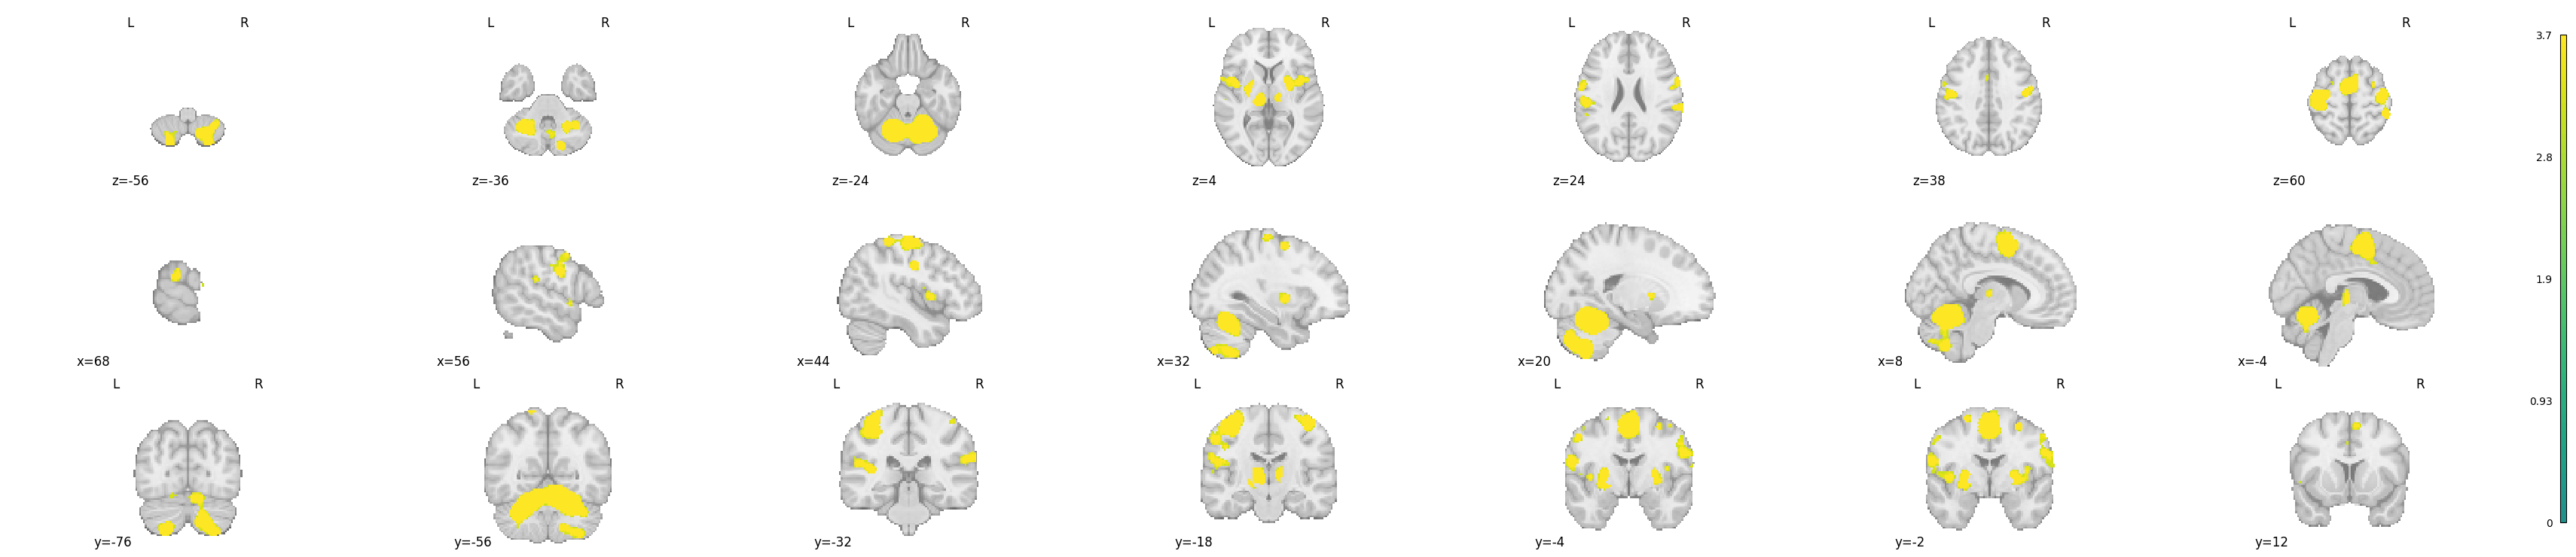

In [11]:
nilearn.plotting.plot_stat_map(macm_nifti, display_mode='mosaic', cmap='viridis')

# Cerebral cortical surface

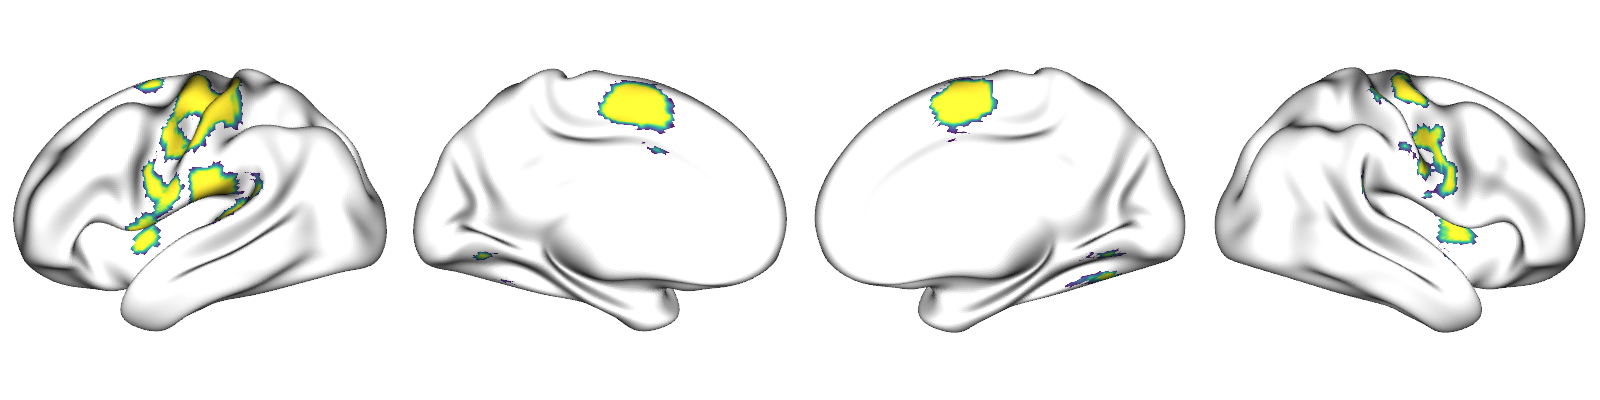

In [12]:
# Note that you can specify a path to save your figure and provide it as argument to the plotting call. We did this in a loop for all domains/ subdomains (see later).

# macm_nift_figure = path.to.yourfigure
macm_fslr = neuromaps.transforms.mni152_to_fslr(macm_nifti, method='linear')
macm_fslr = np.concatenate([macm_fslr[0].agg_data(), macm_fslr[1].agg_data()])
macm_fslr[np.isclose(macm_fslr, 0)] = np.NaN
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
               'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}
plot_surface(macm_fslr, meshes_fslr, cmap='viridis', nan_color=(1, 1, 1, 1))
# plot_surface(macm_fslr, meshes_fslr, filename = macm_nifti_figure, cmap='viridis', nan_color=(1, 1, 1, 1))

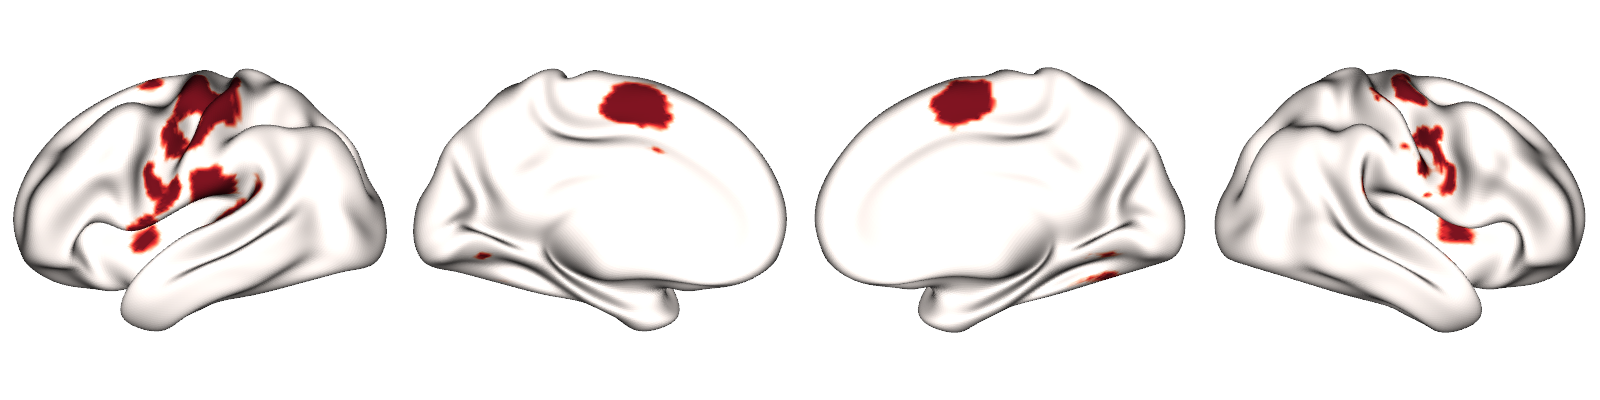

In [13]:
# And with our custom cmap!
tmp_filename = tempfile.mktemp('.nii.gz')
macm_bin.to_filename(tmp_filename)
macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
meshes_fslr = {'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
               'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)}
plot_surface(macm_bin_fslr, meshes_fslr, cmap='Reds', nan_color=(0.65, 0.65, 0.65, 1.0))

# Loop over domains
## We used binarized locations of thresholded maps.

In [14]:
# Binarized Z-values of thesholded maps

from IPython.display import display

# Minimal list of domains
domains = ['Action', 'Cognition'] # 'Emotion', 'Interoception', 'Perception' not reported in main figure because non-existent (emotion), empty (interoception), or uninteresting (perception) results.


# Base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Cerebral_Cortex/Domains')

# Iterate over each subdomain and construct file paths
for domain in domains:
    # Construct the file path for the current domain and subdomain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        # Create the directory for saving the figure
        figure_dir = os.path.join(base_figure_dir, f'{domain}')
        os.makedirs(figure_dir, exist_ok=True)  # Create directory if it doesn't exist
            
        # Define the full file path for saving the figure (including file extension)
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        macm_bin_figure = os.path.join(figure_dir, f'{domain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')

        tmp_filename = tempfile.mktemp('.nii.gz')
        macm_bin.to_filename(tmp_filename)
        # Convert NIfTI to FSLR space and process the data
        macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
        macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
        # macm_bin_fslr[np.isclose(macm_bin_fslr, 0)] = np.NaN  
            
        # Display and save the surface plot
        display(plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
    else:
         print(f"File path does not exist for subdomain: {domain}.{subdomain}. Skipping...")

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Cerebral_Cortex/Domains/Action/Action_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Cerebral_Cortex/Domains/Cognition/Cognition_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

## Loop over subdomains

In [15]:
# Add nicer labels to the sets of experiments/subdomains.
subdomain_labels = {'Action.MotorLearning': 'Motor Learning',
                  'Action.Observation': 'Observation',
                  'Action.Execution.Speech': 'Speech Execution',
                  'Action.Inhibition': 'Inhibition',
                  'Action.Execution': 'Execution',
                  'Action.Preparation': 'Preparation',
                  'Action.Imagination': 'Imagination',
                  'Cognition.Spatial': 'Spatial',
                  'Cognition.SocialCognition': 'Social Cognition',
                  'Cognition.Attention': 'Attention',
                  'Cognition.Language.Syntax': 'Syntax',
                  'Cognition.Memory': 'Memory',
                  'Cognition.Memory.Explicit': 'Explicit Memory',
                  'Cognition.Language': 'Language',
                  'Cognition.Language.Semantics': 'Semantics',
                  'Cognition.Memory.Working': 'Working Memory',
                  'Cognition.Language.Phonology': 'Phonology',
                  'Cognition.Reasoning': 'Reasoning',
                  'Cognition.Temporal': 'Temporal',
                  'Cognition.Language.Speech': 'Speech',
                  'Cognition.Language.Orthography': 'Orthography',
                  'Cognition.Music': 'Music',
                  'Emotion.Positive.RewardGain': 'Reward/ Gain',
                  'Emotion.Negative.Disgust': 'Disgust',
                  'Emotion.Positive': 'Positive Emotion',
                  'Emotion.Negative.Fear': 'Fear',
                  'Emotion.Positive.Happiness': 'Happiness',
                  'Emotion.Negative.Sadness': 'Sadness',
                  'Emotion.Negative': 'Negative Emotion',
                  'Emotion.Valence': 'Valence',
                  'Emotion.Negative.Anger': 'Anger',
                  'Emotion.Negative.Anxiety': 'Anxiety',
                  'Perception.Vision': 'Vision',
                  'Perception.Olfaction': 'Olfaction',
                  'Perception.Vision.Motion': 'Vision - Motion',
                  'Perception.Gustation': 'Gustation',
                  'Perception.Somesthesis.Pain': 'Pain',
                  'Perception.Audition': 'Audition',
                  'Perception.Somesthesis': 'Somesthesis',
                  'Perception.Vision.Color': 'Vision - Color',
                  'Perception.Vision.Shape': 'Vision - Shape',
                  'Interoception.Sexuality': 'Sexuality',
                  'Interoception.RespirationRegulation': 'Respiration Regulation',
                  'Interoception.Hunger': 'Hunger'
  
}

In [16]:
# Thresholded (Binarized)
from IPython.display import display
meshes_fslr = {
    'L': str(neuromaps.datasets.fetch_fslr()['inflated'].L), 
    'R': str(neuromaps.datasets.fetch_fslr()['inflated'].R)
}

# Minimal list of subdomains for figure 5
subdomains = ['Language', 'Memory.Working', 'SocialCognition'] # Just skip this if you want to create folders/ figures for every available subdomain.

# Base directory for saving figures
base_figure_dir = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Cerebral_Cortex/Subdomains/')

# Iterate over each subdomain and construct file paths
for subdomain in subdomains:
    for domain in domains:
        # Construct the file path for the current domain and subdomain
        macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}.{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')
        
        # Check if the file path exists
        if os.path.exists(macm_nifti):
            # Create the directory for saving the figure
            figure_dir = os.path.join(base_figure_dir, f'{domain}.{subdomain}')
            os.makedirs(figure_dir, exist_ok=True)  # Create directory if it doesn't exist
            
            # Define the full file path for saving the figure (including file extension)
            macm_bin = nilearn.image.binarize_img(macm_nifti)
            macm_bin_figure = os.path.join(figure_dir, f'{subdomain}_MACM_Cerebral-Cortex-Surface_p001_K50-binarized')

            tmp_filename = tempfile.mktemp('.nii.gz')
            macm_bin.to_filename(tmp_filename)
            # Convert NIfTI to FSLR space and process the data
            macm_bin_fslr = neuromaps.transforms.mni152_to_fslr(tmp_filename, method='linear')
            macm_bin_fslr = np.concatenate([macm_bin_fslr[0].agg_data(), macm_bin_fslr[1].agg_data()])
            # macm_bin_fslr[np.isclose(macm_bin_fslr, 0)] = np.NaN  
            
            # Display and save the surface plot
            display(plot_surface(macm_bin_fslr, meshes_fslr, filename=macm_bin_figure, cmap='Reds', nan_color=(1, 1, 1, 1)))
        else:
            print(f"File path does not exist for subdomain: {domain}.{subdomain}. Skipping...")

File path does not exist for subdomain: Action.Language. Skipping...


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Cerebral_Cortex/Subdomains/Cognition.Language/Language_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for subdomain: Action.Memory.Working. Skipping...


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Cerebral_Cortex/Subdomains/Cognition.Memory.Working/Memory.Working_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

File path does not exist for subdomain: Action.SocialCognition. Skipping...


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Cerebral_Cortex/Subdomains/Cognition.SocialCognition/SocialCognition_MACM_Cerebral-Cortex-Surface_p001_K50-binarized.png'

# Subcortex (volumetric)

In [17]:
# We first make sure that only MACM-results within the Tian subcortical parcellation remains!
## NB this cropping can also be used to restrict plotting to the subcortex.
subcortex_mask = nilearn.image.binarize_img(
        os.path.join(INPUT_DIR, 'maps', 'Tian_Subcortex_S1_3T.nii')
    )
subctx_crop = nilearn.image.crop_img(subcortex_mask)
macm_bin_crop = nilearn.image.resample_to_img(macm_bin, subctx_crop)
mni_crop = nilearn.image.resample_to_img(
    nilearn.datasets.load_mni152_template(2), 
    subctx_crop)

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


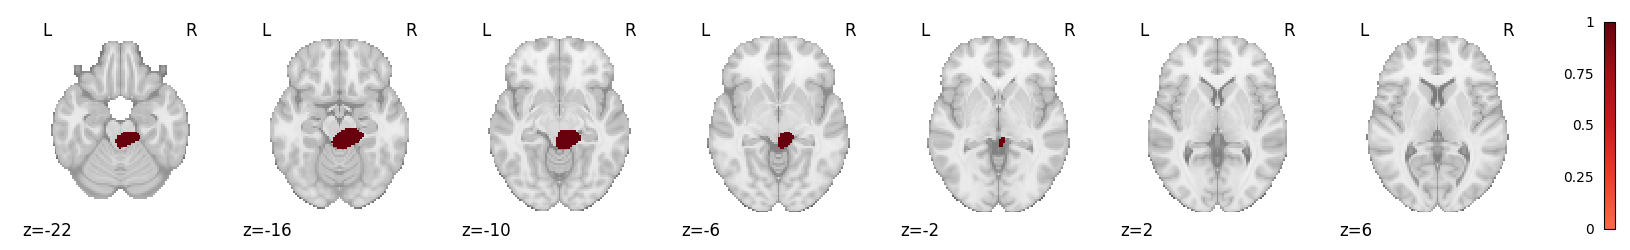

In [18]:
nilearn.plotting.plot_stat_map(
    macm_bin_crop,
    # bg_img=mni_crop,
    cmap='Reds',
    display_mode='z', 
    cut_coords=[-22, -16, -10, -6, -2, 2, 6], # We selected 7 z-coordinates to give a good cut throught the subcortex.
)

# Loop over domains

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


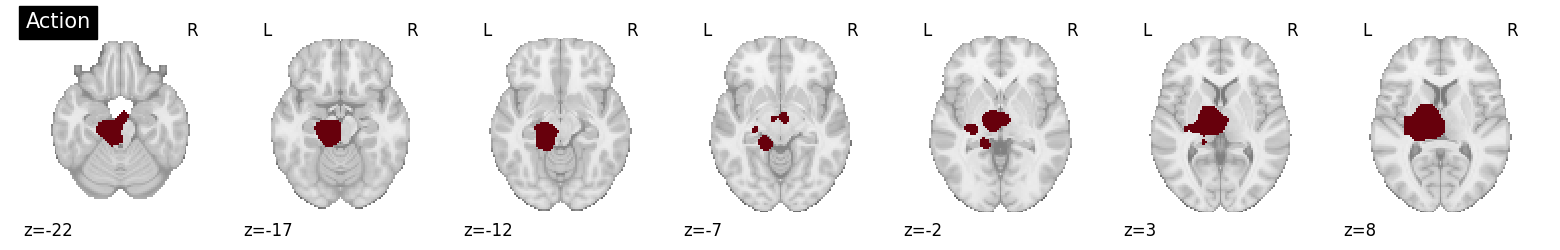

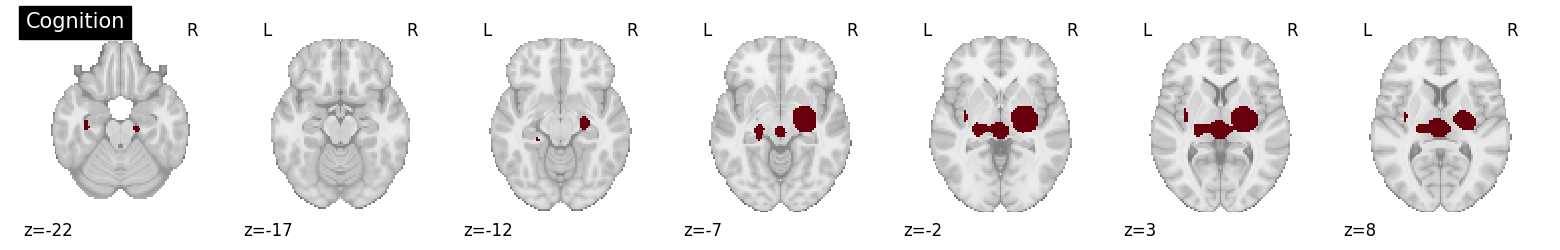

In [44]:
# Shortened list of domains
domains = ['Action', 'Cognition']

# Iterate over each domain and construct file paths
for domain in domains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Input data is the same MACM nifti.
    
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        macm_bin_figure = os.path.join(BASE_DIR, f'Figures/MACM_maps/Figure5/Subcortex/Domains/{domain}/{domain}_MACM_Subcortex-Zstack_p001_K50-binarized') # Figure path
        
        # Ensure the directory structure exists
        os.makedirs(os.path.dirname(macm_bin_figure), exist_ok=True)
        
        # Crop the subcortex mask
        subctx_crop = nilearn.image.crop_img(subcortex_mask)
        
        # Check if the cropped subcortex mask is not empty
        if subctx_crop.shape != (1, 1, 1):
            # Resample the binarized MACM map to match the dimensions of the cropped subcortex mask
            macm_bin_crop = nilearn.image.resample_to_img(macm_bin, subctx_crop)
            
            # Plot the binarized map
            display = nilearn.plotting.plot_stat_map(
                macm_bin_crop,
                cmap='Reds',
                display_mode='z', 
                colorbar=False,
                cut_coords=[-22, -17, -12, -7, -2, 3, 8],
                title=domain,
            )
            
            # Save the plot to the specified path
            display.savefig(f'{macm_bin_figure}.png')
        else:
            print(f"The cropped subcortex mask is empty for domain: {domain}. Skipping...")
            continue  # Skip further processing for this domain if the map is empty
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

# Loop over subdomains

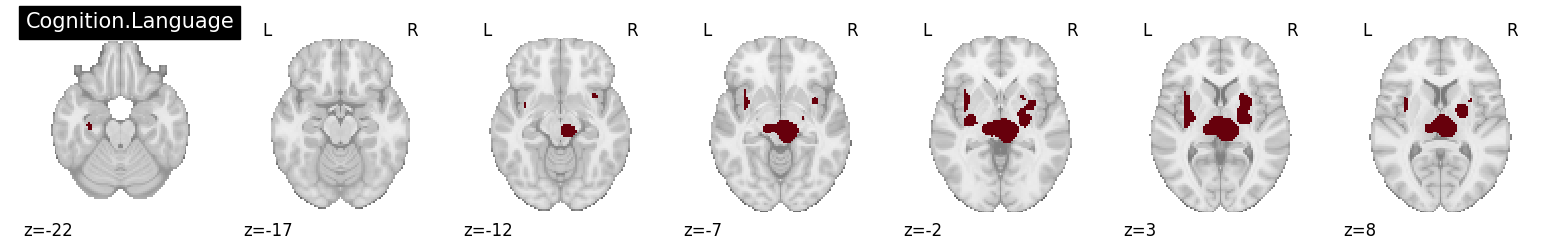

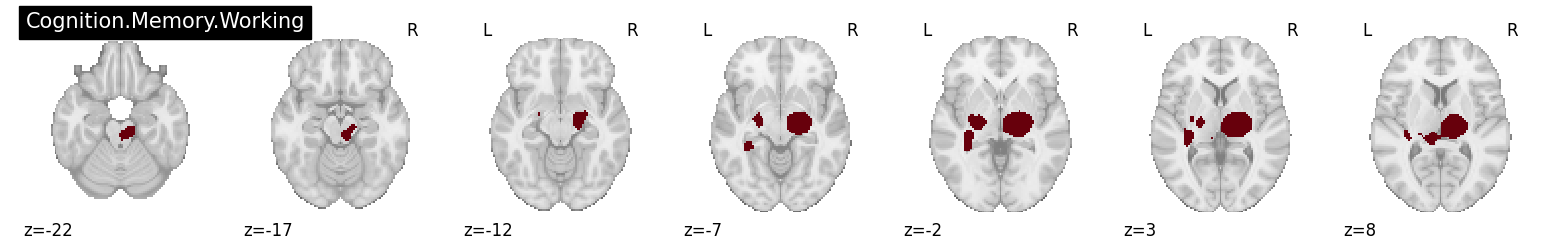

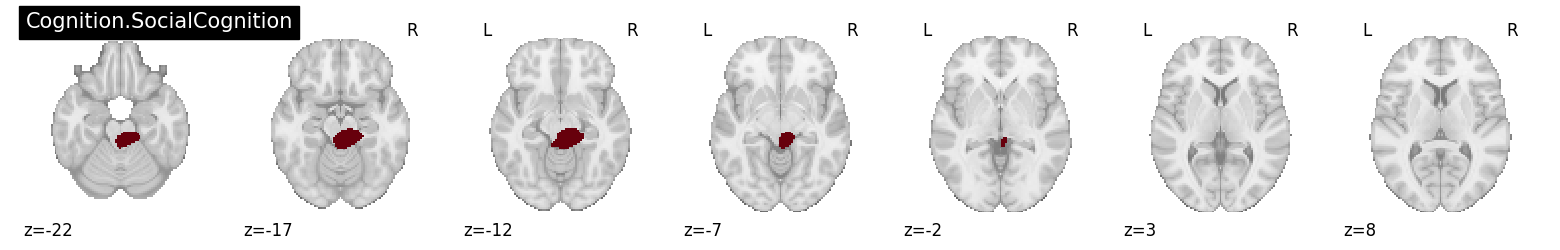

In [46]:
# Shortened list of domains
subdomains = ['Cognition.Language', 'Cognition.Memory.Working', 'Cognition.SocialCognition']

# Iterate over each domain and construct file paths
for subdomain in subdomains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz') # Input data is the same MACM nifti.
    
    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti)
        macm_bin_figure = os.path.join(BASE_DIR, f'Figures/MACM_maps/Figure5/Subcortex/Subomains/{subdomain}_MACM_Subcortex-Zstack_p001_K50-binarized') # Figure path
        
        # Ensure the directory structure exists
        os.makedirs(os.path.dirname(macm_bin_figure), exist_ok=True)
        
        # Crop the subcortex mask
        subctx_crop = nilearn.image.crop_img(subcortex_mask)
        
        # Check if the cropped subcortex mask is not empty
        if subctx_crop.shape != (1, 1, 1):
            # Resample the binarized MACM map to match the dimensions of the cropped subcortex mask
            macm_bin_crop = nilearn.image.resample_to_img(macm_bin, subctx_crop)
            
            # Plot the binarized map
            display = nilearn.plotting.plot_stat_map(
                macm_bin_crop,
                cmap='Reds',
                display_mode='z', 
                colorbar=False,
                cut_coords=[-22, -17, -12, -7, -2, 3, 8],
                title=subdomain,
            )
            
            # Save the plot to the specified path
            display.savefig(f'{macm_bin_figure}.png')
        else:
            print(f"The cropped subcortex mask is empty for subdomain: {subdomain}. Skipping...")
            continue  # Skip further processing for this domain if the map is empty
    else:
        print(f"File path does not exist for subdomain: {subdomain}. Skipping...")

# Cerebellar flatmap (MACM-results and seed overlay).

# Plot as a loop over domains/ subdomains
## We also add borders of the C-SALE seed onto each.

In [19]:
## Cerebellar SALE for 6mm dilated masks (replotted on Diedrichsen et al. 2009)
zmaps = {}
surf_zmaps = {}
zmaps_thr = {}
zmaps_thr_bin = {}
surf_zmaps_thr = {}
surf_zmaps_thr_bin = {}

domains = ['Action', 'Cognition'] # Minimal list for Figure 5
subdomains = ['Action', 'Cognition','Cognition.Language', 'Cognition.Memory.Working', 'Cognition.SocialCognition'] # Just skip this if you want to create folders/ figures for every available subdomain.

MASK_NAME = 'D2009_MNI'
mask_img = os.path.join (INPUT_DIR, f'maps/{MASK_NAME}.nii.gz')
k = 50

for domain in domains:
    domain_path = os.path.join(OUTPUT_DIR, 'SALE', f'{domain}')
    # subdomains = os.listdir(domain_path) # Could be used instead of the above minimal selection.
    for subdomain in subdomains:
        subdomain_path = os.path.join(domain_path, subdomain)
        if (not os.path.isdir(subdomain_path)):
            continue
        print(subdomain)
        # load uncorrected results
        z_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_z.nii.gz'))
        # mask to the proper mask
        z_masked = nilearn.image.math_img("m * img", img=z_orig, m=mask_img)
        # record 3d and flattened unthresholded images
        zmaps[subdomain] = z_masked
        surf_zmaps[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps[subdomain], space = 'SPM').squeeze()
        # do cluster extent thresholding if needed
        corr_cluster_z_path = os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_z.nii.gz')
        if not os.path.exists(corr_cluster_z_path):
            logp_orig = nibabel.load(os.path.join(subdomain_path, 'uncorr_logp.nii.gz'))
            logp_masked = nilearn.image.math_img("m * img", img=logp_orig, m=mask_img)
            # cluster extent correction
            cres = cluster_extent_correction({'z': z_masked, 'logp': logp_masked}, k=50, height_thr=0.01)
            # save corrected results
            for map_name, img in cres.items():
                img.to_filename(os.path.join(subdomain_path, f'corr_cluster_h-001_k-{k}_mask-{MASK_NAME}_{map_name}.nii.gz'))
        # record 3d and flattened thresholded images
        zmaps_thr[subdomain] = nibabel.load(corr_cluster_z_path)
        zmaps_thr_bin[subdomain] = nilearn.image.binarize_img(zmaps_thr[subdomain]) # Binarize!
        surf_zmaps_thr[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr[subdomain]).squeeze()
        surf_zmaps_thr_bin[subdomain] = SUITPy.flatmap.vol_to_surf(zmaps_thr_bin[subdomain], space= 'SPM').squeeze() ## This step is essential for displaying the extent of the (volumetric) clusters correctly onto the flatmap.
# Add stats = 'mode' for the more conservative borders (this maps only cerebeller flatmap voxels where there is a significant cluster at 3 or more of the 6 GM depths).

Action


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


Cognition


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


Cognition.Language


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


Cognition.Memory.Working


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


Cognition.SocialCognition


/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [20]:
# Function to obtain the borders of C-SALE clusters on the cerebellar flatmap.

def get_flatmap_mask_boundaries(domain, surf_zmaps_thr_bin): ## Make sure to use the binarized maps for both SALE and SCALE thresholded outputs.
    mask = (surf_zmaps_thr_bin[domain] > 0).astype(int)
    outline = np.zeros_like(mask, dtype=int)
    mesh = nilearn.surface.load_surf_mesh('/data/project/cerebellum_ale/input/maps/FLAT.surf.gii')
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & \
        set(np.where(mask)[0])
    )
    outline[mask_boundary_verts] = 1
    return outline

# First, plot domains.

In [21]:
# Dictionary to store boundaries for each domain
boundaries_dict = {}

# Iterate over domains and compute boundaries
for domain in domains:
    boundaries_dict[domain] = get_flatmap_mask_boundaries(domain, surf_zmaps_thr_bin)

# This should now have put boundaries for every domain in boundaries_dict
# Check that keys exist for all domains.

In [22]:
# Create the borders

# Load the surface mesh
surface_mesh_file = os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii')
mesh = nilearn.surface.load_surf_mesh(surface_mesh_file)

# Initialize dictionaries to store cluster borders, outline, and boundary faces for each domain
cluster_borders_dict = {}
outline_dict = {}
boundary_faces_dict = {}

# Loop over domains
for domain in domains:
    # Get the binary mask for the current domain
    mask = (surf_zmaps_thr_bin[domain] > 0).astype(int)

    # Get the coordinates of the boundary vertices for the current domain
    outline_dict[domain] = np.zeros_like(mask, dtype=int)
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & set(np.where(mask)[0])
    )
    cluster_borders_dict[domain] = mesh.coordinates[mask_boundary_verts]

    # Smoothing iterations
    iterations = 2
    for i in range(iterations):
        distmat = scipy.spatial.distance_matrix(cluster_borders_dict[domain], cluster_borders_dict[domain])
        distmat[distmat == 0] = np.NaN
        neighbors = np.where(distmat < 5)
        new_points = (cluster_borders_dict[domain][neighbors[0]] + cluster_borders_dict[domain][neighbors[1]]) / 2
        cluster_borders_dict[domain] = np.concatenate([cluster_borders_dict[domain], new_points], axis=0)

In [71]:
# Define the base directory for saving figures
save_dir_base = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Cerebellum/Domains/')

for domain in domains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{domain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis (ax) associated with the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.
        # see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
        # and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

        surface_data = surface_map[0]  # Get the surface map data (NumPy array)
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
 
        # Overlay the cluster borders on top
        ax.plot(cluster_borders_dict[domain][:, 0], cluster_borders_dict[domain][:, 1], # Enable borders if desired.
               color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
        
        # Set the title for the plot
        ax.set_title(domain, fontsize=14)
        
        # Define the directory path for saving the figure
        save_dir_domain = os.path.join(save_dir_base, domain)
        os.makedirs(save_dir_domain, exist_ok=True)  # Create the directory if it doesn't exist
        
        # Define the file name for saving the figure
        save_filename = f"{domain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_domain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        # Display the plot (optional)
        # display(plt.gcf())
        
        # Close the plot
        plt.close()
        
    else:
        print(f"File path does not exist for domain: {domain}. Skipping...")

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


# Then, subdomains.

In [23]:
# Dictionary to store boundaries for each domain
boundaries_dict = {}

# Iterate over domains and compute boundaries
for subdomain in subdomains:
    boundaries_dict[subdomain] = get_flatmap_mask_boundaries(subdomain, surf_zmaps_thr_bin)

# This should now have put boundaries for every domain in boundaries_dict
# Check that keys exist for all domains.

In [24]:
# Create the borders

# Load the surface mesh
surface_mesh_file = os.path.join(INPUT_DIR, 'maps/FLAT.surf.gii')
mesh = nilearn.surface.load_surf_mesh(surface_mesh_file)

# Initialize dictionaries to store cluster borders, outline, and boundary faces for each domain
cluster_borders_dict = {}
outline_dict = {}
boundary_faces_dict = {}

# Loop over domains
for subdomain in subdomains:
    # Get the binary mask for the current domain
    mask = (surf_zmaps_thr_bin[subdomain] > 0).astype(int)

    # Get the coordinates of the boundary vertices for the current domain
    outline_dict[subdomain] = np.zeros_like(mask, dtype=int)
    boundary_faces = (mask[mesh.faces].sum(axis=1) == 1)
    mask_boundary_verts = list(
        set(mesh.faces[boundary_faces].flatten()) & set(np.where(mask)[0])
    )
    cluster_borders_dict[subdomain] = mesh.coordinates[mask_boundary_verts]

    # Smoothing iterations
    iterations = 2
    for i in range(iterations):
        distmat = scipy.spatial.distance_matrix(cluster_borders_dict[subdomain], cluster_borders_dict[subdomain])
        distmat[distmat == 0] = np.NaN
        neighbors = np.where(distmat < 5)
        new_points = (cluster_borders_dict[subdomain][neighbors[0]] + cluster_borders_dict[subdomain][neighbors[1]]) / 2
        cluster_borders_dict[subdomain] = np.concatenate([cluster_borders_dict[subdomain], new_points], axis=0)

In [74]:
# Define the base directory for saving figures
save_dir_base = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Cerebellum/Subdomains/')

subdomains = ['Cognition.Language', 'Cognition.Memory.Working', 'Cognition.SocialCognition'] # For a minimal list of subdomains

for subdomain in subdomains:
    # Construct the file path for the current domain
    macm_nifti = os.path.join(OUTPUT_DIR, f'SALE/{domain}/{subdomain}/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')

    # Check if the file path exists
    if os.path.exists(macm_nifti):
        macm_bin = nilearn.image.binarize_img(macm_nifti) # Binarization
        # Create a new figure and plot the surface data
       
        # Get the current axis (ax) associated with the plot
        ax = plt.gca()

        # Create a new figure and plot the surface data
        surface_map = SUITPy.flatmap.vol_to_surf(macm_bin, space = 'SPM').squeeze(), # Stats and space. Currently nanmean, but can be set to mode if a more conservative plot is desired.
        # see https://suitpy.readthedocs.io/en/latest/reference.html,  Diedrichsen et al. (2015) https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133402
        # and https://github.com/DiedrichsenLab/SUITPy/blob/79ba5656fa284d226357108b95d81c996275e10e/SUITPy/flatmap.py#L33 for details. 

        surface_data = surface_map[0]  # Get the surface map data (NumPy array)
        binarized_surface_data = np.where(surface_data > 0, 1, 0) # We need to binarize again, since stats = 'nanmean' (default) averages across 6 GM depths and thus efectively removes binarization in our maps.
            
        # Plot the flatmap for the current subdomain
        SUITPy.flatmap.plot(binarized_surface_data, colorbar=False, cmap=custom_cmap, underscale = [-0.3, 1],  new_figure=False)
 
        # Overlay the cluster borders on top
        ax.plot(cluster_borders_dict[subdomain][:, 0], cluster_borders_dict[subdomain][:, 1], # Enable borders if desired.
               color='black', marker='.', linestyle=None, markersize=0.01, linewidth=0)
        
        # Set the title for the plot
        ax.set_title(subdomain, fontsize=14)
        
        # Define the directory path for saving the figure
        save_dir_subdomain = os.path.join(save_dir_base, subdomain)
        os.makedirs(save_dir_subdomain, exist_ok=True)  # Create the directory if it doesn't exist
        
        # Define the file name for saving the figure
        save_filename = f"{subdomain}_MACM_Cerebellum-Surface_p001_K50_wborders.png"
        
        # Define the full path to save the figure
        save_path = os.path.join(save_dir_subdomain, save_filename)
        
        # Save the figure to the specified path
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        # Display the plot (optional)
        # display(plt.gcf())
        
        # Close the plot
        plt.close()
        
    else:
        print(f"File path does not exist for subdomain: {subdomain}. Skipping...")

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new

# Plot the parcellations too.

# Create the Cole-Anticevic atlas in fsLR space using Glasser parcellation and this file: https://github.com/ColeLab/ColeAnticevicNetPartition/blob/master/cortex_community_order.txt

In [25]:
meshes = {
    'L': str(neuromaps.datasets.fetch_fslr()['midthickness'][0]),
    'R': str(neuromaps.datasets.fetch_fslr()['midthickness'][1])
}

In [26]:
# Register the CA colormapping.
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3]=1
ca_cmap = LinearSegmentedColormap.from_list('CA', ca_colors, 13)
plt.register_cmap('CA', ca_cmap) # Only necessary once.

# Save the surface plot

In [27]:
# Save the surface plot
ca_ctx = hcp.cortex_data(hcp.ca_network['map_all'])
plot_surface(ca_ctx, meshes, cmap='CA', filename= os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Parcellations/Cole-Anticevic13_cerebralCX'))

'/data/project/cerebellum_ale/Figures/MACM_maps/Figure5/Parcellations/Cole-Anticevic13_cerebralCX.png'

## Add a label

In [28]:
abbrev_labels = os.path.join(INPUT_DIR, 'maps/cole-anticevic_labels.txt')

In [29]:
# Ensure the first color is fully opaque
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3] = 1

# Extract the actual labels from the dictionary values
labels = [label for label in hcp.ca_network['labels'].values()]

# Create legend patches, starting from the second item
patches = [Patch(color=ca_colors[i + 1], label=label) for i, label in enumerate(labels[1:])]

# Create a new figure for the legend
fig_legend = plt.figure(figsize=(4, 18))
fig_legend.legend(handles=patches, loc='center', ncol=1, fontsize = 10)

# Save the legend as an image
legend_filename = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Parcellations/Cole-Anticevic13_legend.png')
fig_legend.savefig(legend_filename, bbox_inches='tight', pad_inches=0)

<Figure size 400x1800 with 0 Axes>

In [89]:
# Abbreviated

# Read the abbreviations file
with open(abbrev_labels, 'r') as f:
    label_mapping = f.readlines()

# Parse the abbreviations file to extract labels and colors
labels = []
for line in label_mapping:
    label = line.strip()
    labels.append(label)

# Ensure the first color is fully opaque
ca_colors = list(hcp.ca_network['rgba'].values())
ca_colors[0][3] = 1

# Create legend patches
patches = [Patch(color=ca_colors[i + 1], label=label) for i, label in enumerate(labels)]

# Create a new figure for the legend
fig_legend = plt.figure(figsize=(4, 18))
fig_legend.legend(handles=patches, loc='center', ncol=1, fontsize=10)

# Set font to Asana Math
for text in fig_legend.texts:
    text.set_fontname('Asana Math')
    
# Save the legend as an image
legend_filename = os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Parcellations/Cole-Anticevic13_legend-abbrev.png')
fig_legend.savefig(legend_filename, bbox_inches='tight', pad_inches=0)

<Figure size 400x1800 with 0 Axes>

# Cerebellar lobules

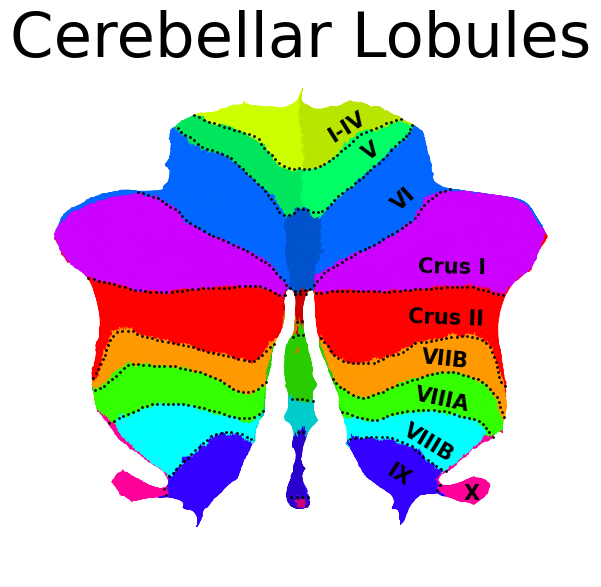

In [31]:
# Load the GIFTI file
G = nibabel.load(os.path.join(INPUT_DIR, 'maps/Lobules.label.gii'))

# Plot the flatmap with SUIT
flatmap_plot = SUITPy.flatmap.plot(G, overlay_type='label')

# Set the title of the plot
flatmap_plot.set_title('Cerebellar Lobules', fontsize=45, y=0.95)

# Manually add the lobule labels at specific locations and with rotations
manual_labels = ['I-IV', 'V', 'VI', 'Crus I', 'Crus II', 'VIIB', 'VIIIA', 'VIIIB', 'IX', 'X']
manual_label_positions = [(0.585, 0.835), (0.63, 0.79), (0.69, 0.70), (0.78, 0.575), (0.767, 0.48), (0.767, 0.405), (0.760, 0.330), (0.735, 0.25), (0.68, 0.190), (0.815, 0.155)]
manual_label_rotations = [32, 34, 42, -1, -2, -6, -12, -31, -32, 0]

for label, position, rotation in zip(manual_labels, manual_label_positions, manual_label_rotations):
    flatmap_plot.text(position[0], position[1], label, fontsize=15, ha='center', va='center', transform=flatmap_plot.transAxes, rotation=rotation, fontweight='bold')

# plt.show()
plt.savefig(os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Parcellations/Cerebellar_lobules.png'), dpi = 300)

# Subcortex (Tian et al. 2020 Parcellation)

In [32]:
def mni_get_subcortex(nifti):
    subcortex_mask = nilearn.image.binarize_img(
        os.path.join(INPUT_DIR, 'maps', 'Tian_Subcortex_S1_3T.nii')
    )
    subcortex_array = nilearn.masking.apply_mask(nifti, subcortex_mask)
    subcortex_img = nilearn.masking.unmask(subcortex_array, subcortex_mask)
    return subcortex_img

In [33]:
tian_nifti = os.path.join(INPUT_DIR, 'maps/Tian_Subcortex_S1_3T.nii')
tian_bin = nilearn.image.binarize_img(tian_nifti)

/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [35]:
# Path to your labels file
labels_file = os.path.join(INPUT_DIR, 'maps/Tian_Subcortex_S1_3T_label.txt')

# Read the labels
with open(labels_file, 'r') as file:
    labels = [line.strip() for line in file.readlines()]


In [36]:
# Define a list of colors for each category
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8',
    '#f58231', '#911eb4', '#46f0f0', '#f032e6',
    '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3'
]

In [37]:
# Load your nifti image
tian_img = nibabel.load(tian_nifti)
tian_data = tian_img.get_fdata()

# Prevent potential compatibility issues with int64
labeled_data = np.zeros(tian_data.shape, dtype=np.int32)

for i, label in enumerate(labels, start=1):
    # Assign a unique integer to each label
    labeled_data[tian_data == i] = i

# Add the labels to the nifti images
labeled_img = nibabel.Nifti1Image(labeled_data, tian_img.affine)


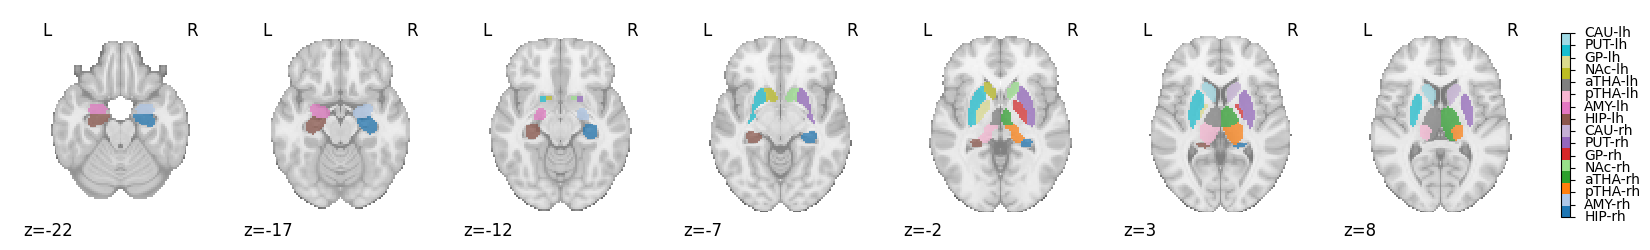

In [40]:
# Colormap
cmap = plt.cm.get_cmap('tab20', len(labels)) # Using 'tab20' as the colormap. Not sure what Tian et al. used and this looks nice.

# Plotting (the labeled image from the previous)
display = plot_roi(
    labeled_img,
    display_mode='z', 
    colorbar=False,  # Disable default colorbar
    cut_coords=[-22, -17, -12, -7, -2, 3, 8],
    cmap=cmap  
)

# Colorbar from matplotlib itself
fig = display.frame_axes.figure
cax = fig.add_axes([1.0, 0.1, 0.02, 0.8]) # Set the position of the colorbar

# Create the colorbar
norm = plt.Normalize(vmin=1, vmax=len(labels))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

# Add colorbar ticks and labels
cbar.set_ticks(np.arange(1, len(labels) + 1))
cbar.set_ticklabels(labels)

# Font size and position of labels
for label in cbar.ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_verticalalignment('center')  # Align labels centrally.

# Adjust the spacing
cbar.ax.tick_params(pad=7)  # Distance between ticks and labels.

# Stretch out the colorbar
cax.set_aspect(1.4)  # Aspect ratio for the colorbar. Some stretch was needed.


# Save the plot
fig.savefig(os.path.join(BASE_DIR, 'Figures/MACM_maps/Figure5/Parcellations/Tian_connectivity-gradient_parcellation.png'), dpi = 300)

# Show the plot
#plt.show()



# The End.